In [2]:
packages <- c("survRM2", "mvtnorm", "ggplot2", "MASS", "tidyr", "survival", "nph",
              "foreach", "doParallel", "cowplot", "IRdisplay", "rlang")

install_and_load <- function(package) {
  if (!require(package, character.only = TRUE)) {
    install.packages(package)
    library(package, character.only = TRUE)
  }
}

invisible(lapply(packages, install_and_load))

n_cores <- detectCores()
n_cores
cluster <- makeCluster(16) 
registerDoParallel(cluster)
# multi thread
invisible(clusterEvalQ(cluster,
  {
  library('survRM2')
  library('mvtnorm')
  library('survival')
  library('nph')
  library("simtrial")
  library("mdir.logrank")
  library('foreach')
  }))

source('Rfiles/Function.R')
clusterExport(cluster, "expo_gen_2stages")

[1] 128

# Experiments

## Single Stage ( Proportional Hazard Assumption)
#### According to Jung (2017) double arms 2 stages log rank test (page 642)   
####  $H_0 : \lambda_0 = \lambda_1 = 1.609$    
####  $H_1 : \lambda_0 = 1.609,\ \lambda_1 = 0.916$  
#### α = 0.1, power = 0.9. Sample size = 102 (51 per arm)   


------

## 1. One sided(greater) Log rank test VS Simple RMST
### 1.1 (Jung 2017 page5 example 1)
#### It is annouced that 2 sample one-sided log rank test with N = 51 per arm 
#### The power can reach 0.9 when α = 0.1. 
#### Simple RMST: Reject $H_0$ when $RMST_E - RMST_C> m_1$


The simulated alpha of one-sided log rank test is: 0.0999 
The simulated alpha of one-sided Simple RMST test is: 0.1055 
************* The empirical alpha is closed to nominated alpha 0.1 ************* 
The simulated power of one-sided log rank test is: 0.9098 
The simulated power of simple rmst test is: 0.9002

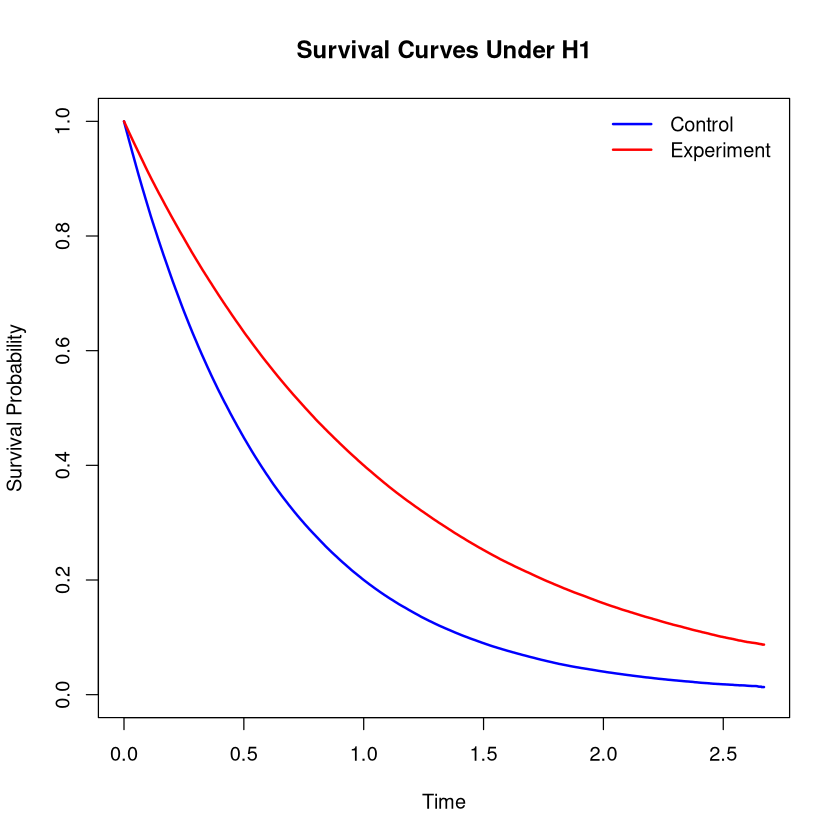

In [4]:
set.seed(2024)
sim_size = 10000
n = 51
acc_time <- 1.67
cen_time <- 1
tau <- 2

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = 1.609, dist = 'exp', 
                                cen_time = cen_time,arm = 0, interim = 0)[ , c(4,5,1)]    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = 1.609, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = 0)[ , c(4,5,1)]
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = 0.916, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = 0)[ , c(4,5,1)]  
# survival curve
pre_data <- rbind(data_C, data_E_H1)
fit <- survfit(Surv(pre_data[,1], pre_data[,2]) ~ pre_data[,3])
plot(fit, col = c("blue", "red"), lwd = 2, xlab = "Time", 
    ylab = "Survival Probability", main = "Survival Curves Under H1")
legend("topright", legend = c("Control", "Experiment"), 
            col = c("blue", "red"), lwd = 2, bty = "n")
# Under H0
log_rank_a <- log_rank_sim(data_C = data_C, data_E = data_E_H0, sim_size = sim_size,
                            n = n,alpha = 0.1 ,sided = 'greater')
simple_rmst_a <- RMST_sim_test(data_C = data_C, data_E = data_E_H0, sim_size = sim_size, tau = tau,
                            n = n,alpha = 0.1 ,sided = 'greater')
cat('The simulated alpha of one-sided log rank test is:', log_rank_a$rejection, '\n')
cat('The simulated alpha of one-sided Simple RMST test is:',simple_rmst_a$test_result$rejection,'\n')
cat('************* The empirical alpha is closed to nominated alpha 0.1 *************','\n')
log_rank_b <- log_rank_sim(data_C = data_C, data_E = data_E_H1, sim_size = sim_size,
                            n = n, alpha = 0.1 ,sided = 'greater')
simple_rmst_b <- RMST_sim_test(data_C = data_C, data_E = data_E_H1, sim_size = sim_size, tau = tau,
                            n = n, alpha = 0.1 ,sided = 'greater')
cat( 'The simulated power of one-sided log rank test is:', log_rank_b$rejection,'\n')
cat('The simulated power of simple rmst test is:', simple_rmst_b$test_result$rejection)

The logrank.test function should be reliable.

### 1.2 Eaton (2020) P288 Table1 (two-sided) Scenario 1

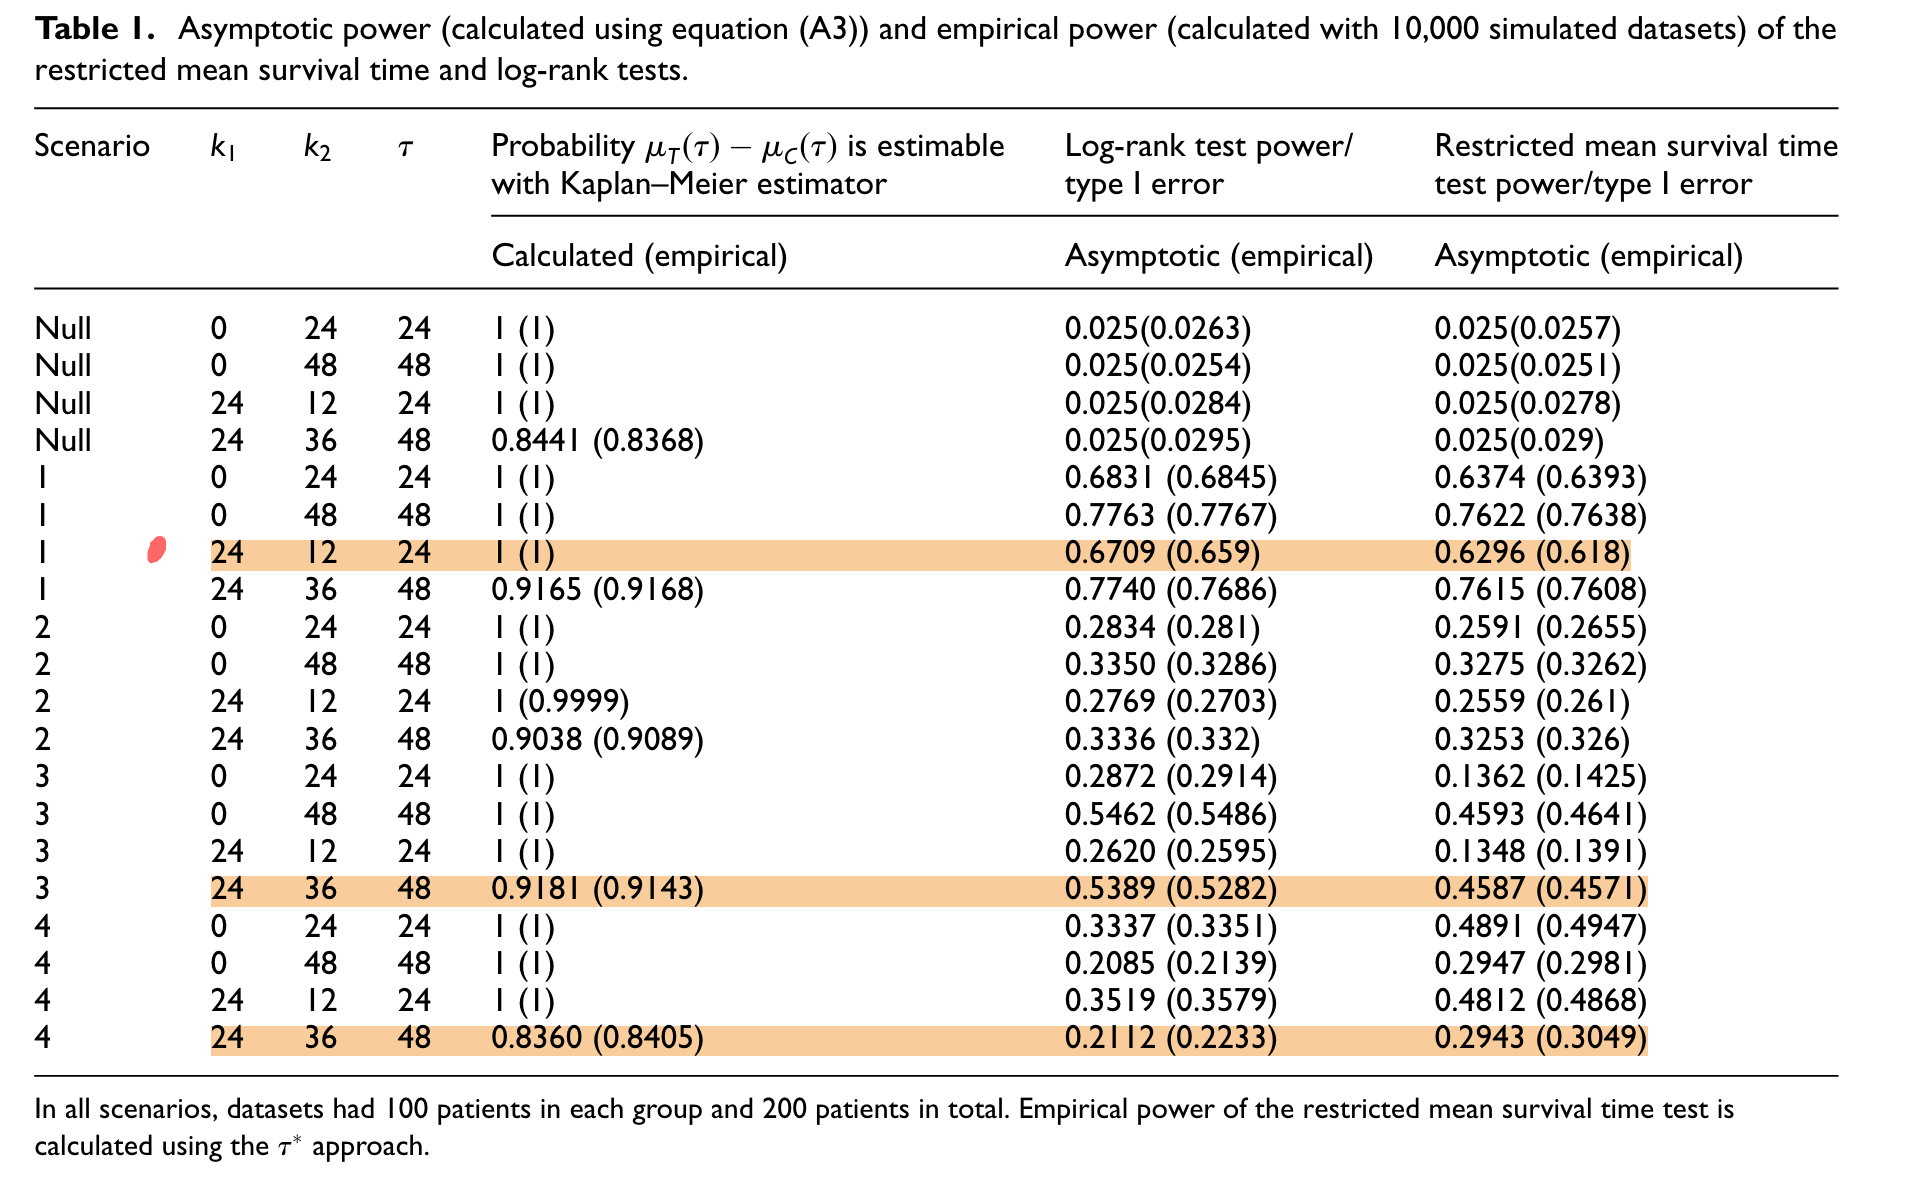

The simulated power of two-sided(alpha = 0.05) log rank test is: 0.6659 
The simulated power of two-sided(alpha = 0.05) simple rmst test is: 0.6229 
************* two sided test in Eaton 2020 *************  
The simulated power of one-sided(alpha = 0.05) log rank test is: 0.7735 
The simulated power of one-sided(alpha = 0.05) simple rmst test is: 0.7392

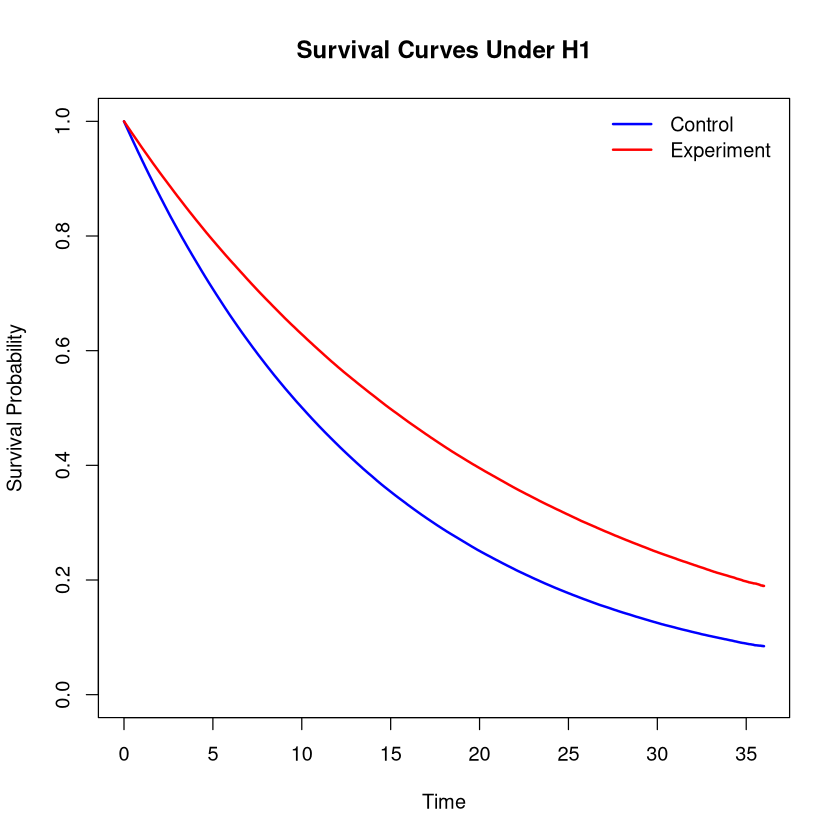

In [5]:
median_con <- 10 # month
lambda_H0 <- log(2)/median_con
lambda_H1 <- lambda_H0 * 0.67
sim_size <- 10000 
acc_time <- 24
cen_time <- 12
tau <- 24
n <- 100  
set.seed(2024)

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = 0)[ , c(4,5,1)]    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                            cen_time = cen_time,arm = 1, interim = 0)[ , c(4,5,1)]
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                            cen_time = cen_time,arm = 1, interim = 0)[ , c(4,5,1)]  
pre_data <- rbind(data_C, data_E_H1)
fit <- survfit(Surv(pre_data[,1], pre_data[,2]) ~ pre_data[,3])
plot(fit, col = c("blue", "red"), lwd = 2, xlab = "Time", 
    ylab = "Survival Probability", main = "Survival Curves Under H1")
legend("topright", legend = c("Control", "Experiment"), 
            col = c("blue", "red"), lwd = 2, bty = "n")
    
# Under H1
log_rank_2 <- log_rank_sim(data_C = data_C, data_E = data_E_H1, sim_size = sim_size,
                            n = n, alpha = 0.05 ,sided = 'two_sided')
simple_rmst_2 <- RMST_sim_test(data_C = data_C, data_E = data_E_H1, sim_size = sim_size, tau = tau,
                            n = n, alpha = 0.05 ,sided = 'two_sided')
log_rank_1 <- log_rank_sim(data_C = data_C, data_E = data_E_H1, sim_size = sim_size,
                            n = n, alpha = 0.05 ,sided = 'greater')
simple_rmst_1 <- RMST_sim_test(data_C = data_C, data_E = data_E_H1, sim_size = sim_size, tau = tau,
                            n = n, alpha = 0.05 ,sided = 'greater')                          
display_jpeg(file='figures/Eaton_2020_table1.JPEG')
cat( 'The simulated power of two-sided(alpha = 0.05) log rank test is:', log_rank_2$rejection,'\n')
cat('The simulated power of two-sided(alpha = 0.05) simple rmst test is:', simple_rmst_2$test_result$rejection,'\n')
cat('************* two sided test in Eaton 2020 ************* ','\n')
cat( 'The simulated power of one-sided(alpha = 0.05) log rank test is:', log_rank_1$rejection,'\n')
cat('The simulated power of one-sided(alpha = 0.05) simple rmst test is:', simple_rmst_1$test_result$rejection)

## Different hazard ratio. Compare power under $\alpha = 0.05$ 
### Ust minimax $\tau$ for simple RMST. 

In [3]:
median_con <- 10 # month
lambda_H1 <- log(2)/median_con
sim_size <- 10000 
acc_time <- 24
cen_time <- 12
tau <- 36  # Set a large tau for minimax tau 
n <- 100  
set.seed(2024)
diff_delta_single <- foreach(delta = seq(1.2, 2, by = 0.1), .combine = rbind) %dopar%
    {
        lambda_H0 <- lambda_H1 * delta
        data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = 0)[ , c(4,5,1)] 
        data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                            cen_time = cen_time,arm = 1, interim = 0)[ , c(4,5,1)]   
        data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                            cen_time = cen_time,arm = 1, interim = 0)[ , c(4,5,1)]
                            
        log_rank_1 <- log_rank_sim(data_C = data_C, data_E = data_E_H1, sim_size = sim_size,
                            n = n, alpha = 0.05 ,sided = 'greater')
        log_rank_0 <- log_rank_sim(data_C = data_C, data_E = data_E_H0, sim_size = sim_size,
                            n = n, alpha = 0.05 ,sided = 'greater')
        simple_rmst_1 <- RMST_sim_test(data_C = data_C, data_E = data_E_H1, sim_size = sim_size, tau = tau,
                            n = n, alpha = 0.05 ,sided = 'greater')

        # Monte Carlo for calculating critical value
        rmst_h0 <- RMST_sim_cal(n = n,data_E = data_E_H0, data_C = data_C,tau = tau, sim_size = sim_size)
        rmst_h1 <- RMST_sim_cal(n = n,data_E = data_E_H1, data_C = data_C,tau = tau, sim_size = sim_size)

        opt_power_rmst <- 0
        for (m1 in seq(from = 0, to = 3, by = 0.02))
            { 
                proc_h0 <- sum((rmst_h0[2, ] - rmst_h0[1, ] > m1))
                proc_h1 <- sum((rmst_h1[2, ] - rmst_h1[1, ] > m1))
                if (proc_h0/sim_size < 0.05 & proc_h1/sim_size >= opt_power_rmst) { 
                    opt_power_rmst <- proc_h1 / sim_size
                    }
            }

        opt_power_lr <- 0
        for (m1 in seq(from = -3, to = 3, by = 0.02))
            { 
                proc_h0 <- sum((log_rank_0$z_stats > m1))
                proc_h1 <- sum((log_rank_1$z_stats > m1))
                if (proc_h0/sim_size < 0.05 & proc_h1/sim_size >= opt_power_lr) {
                    opt_power_lr <- proc_h1 / sim_size
                    }
            }
        
        opt_power_our <- 0
        for (m1 in seq(from = 0, to = 3, by = 0.01))
            { 
            for (t1 in seq(from = 8, to = 14, by = 0.05)) 
                {
                    proc_h0 <- sum((rmst_h0[2, ] - rmst_h0[1, ] > m1) & (rmst_h0[2, ] > t1))
                    proc_h1 <- sum((rmst_h1[2, ] - rmst_h1[1, ] > m1) & (rmst_h1[2, ] > t1))
                    if (proc_h0/sim_size < 0.05 & proc_h1/sim_size >= opt_power_our) {
                        opt_power_our <- proc_h1 / sim_size
                        }
                }
        }

        c(delta, log_rank_1$rejection, simple_rmst_1$test_result$rejection, 
            opt_power_rmst, opt_power_lr, opt_power_our)      
    }

## 5 curves:
### 1. one-sided log rank 
### 2. one-sided simple RMST
### 3. Log rank test (greater) Monte Carlo for $m_1$
### $\textcolor{lightgreen}{\frac{W_1}{\sigma_1}>m_1}$, The normal log rank test statistics
### 4. Simple RMST Monte Carlo for $m_1$
### $\textcolor{lightgreen}{RMST_E - RMST_C > m_1}$
### 5. Our method Monte Carlo
### $ \textcolor{lightgreen}{RMST_E - RMST_C >m_1\ \&\  RMST_E >t_1}$ 

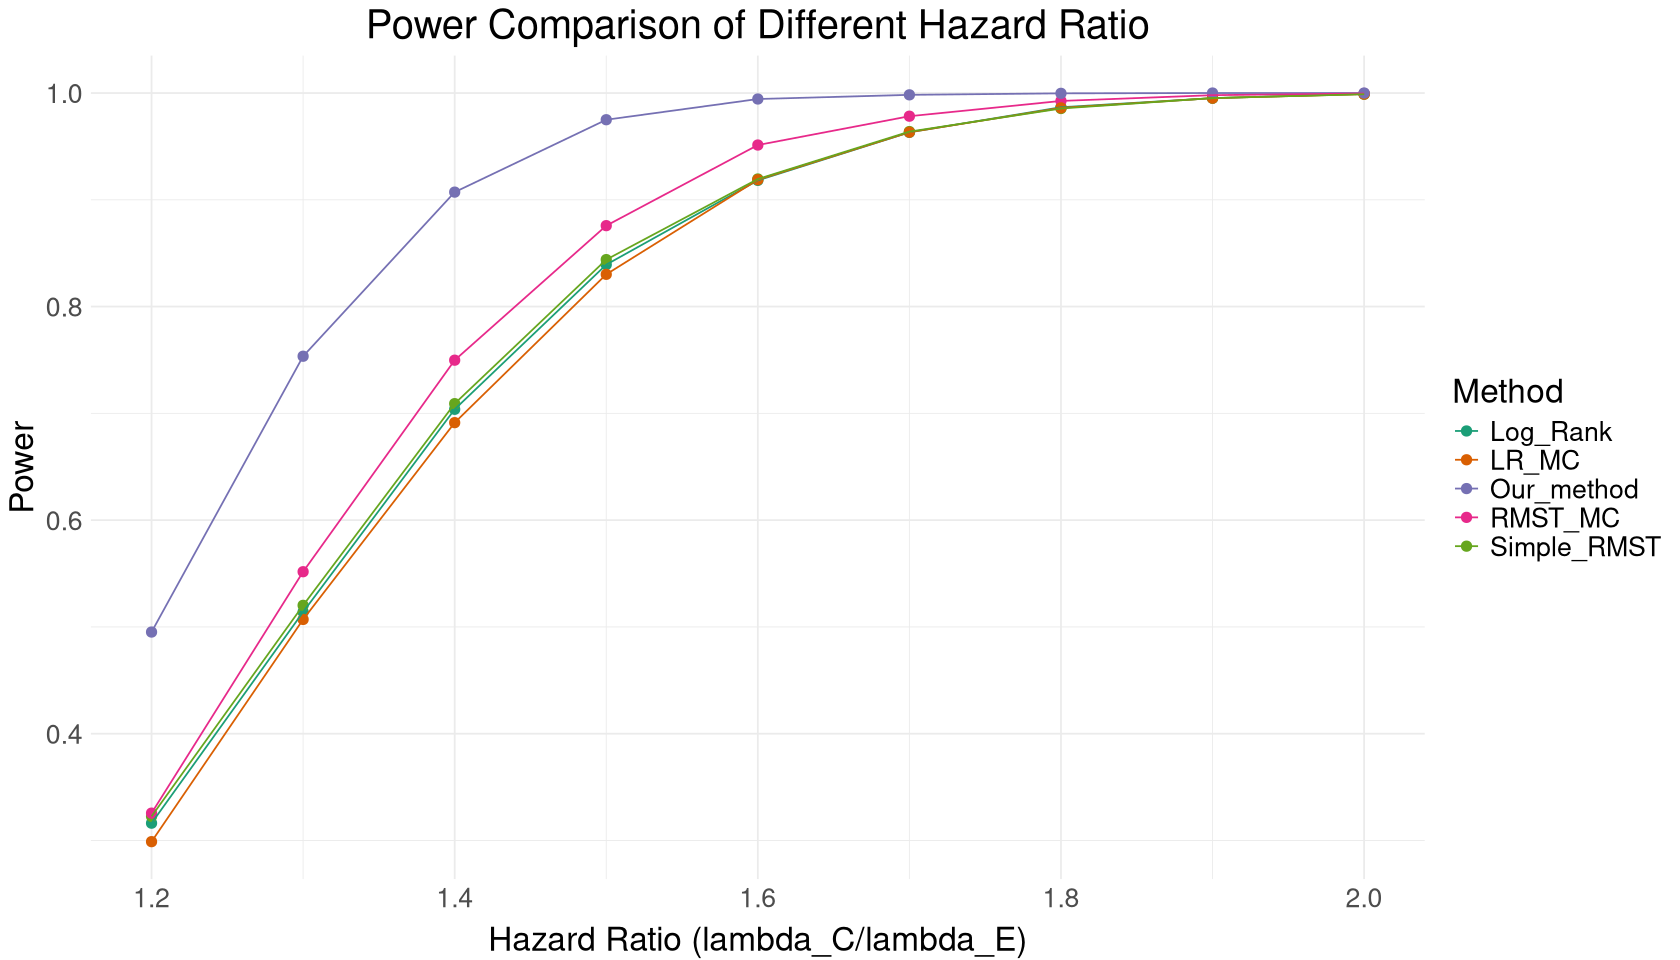

In [10]:
diff_delta_single <- data.frame(diff_delta_single)
colnames(diff_delta_single) <- c('Delta','Log_Rank','Simple_RMST','RMST_MC', 'LR_MC', 'Our_method')
diff_delta_single_long <- diff_delta_single %>% gather(key = "Method", value = "Power", -Delta)
options(repr.plot.width = 14, repr.plot.height = 8)
ggplot(diff_delta_single_long, aes(x = Delta, y = Power, color = Method)) +
  geom_point(size = 2.5) +
  geom_line() +
  scale_color_brewer(palette = "Dark2") +
  theme_minimal() +
  labs(
    color = "Method",
    title = "Power Comparison of Different Hazard Ratio",
    x = "Hazard Ratio (lambda_C/lambda_E)",
    y = "Power"
  ) +
  theme(text = element_text(size = 20),
        axis.title.x = element_text(vjust = 0),
        axis.title.y = element_text(vjust = 1),
        plot.title = element_text(hjust = 0.5))

#### If we use minimax $\tau$ in RMST, the power would be almost the same as log rank
#### There is Monte Carlo error. RMST_MC would perform better but it's not true 
#### Power inflation??? The power of monte carlo should be lower than shown in the graph

-------

# Discussion ( One stage)

### 1. The relationship between power and sample size under this hypothesis.

#### Find the most powerful m1,t1 pairs under each n1. Larger sample size should lead to a larger $\beta$


In [15]:
sim_size <- 10000  #simulate 10000 pairs of (E,C) under H0 and H1 respectively
acc_time <- 1.67
cen_time <- 1
tau <- 2
set.seed(2024)

result_alln1 <- foreach(n1 = 35:55, .combine = 'cbind',.packages = 'foreach') %dopar% {  
    #n1 here is the sample size per arm
    data_C <- expo_gen_2stages(N = n1 * sim_size, acc_time = acc_time, lambda = 1.609, dist = 'exp', 
                                cen_time = cen_time,arm = 0, interim = 1)[ , c(4,5,1)]    
    data_E_H0 <- expo_gen_2stages(N = n1 * sim_size, acc_time = acc_time, lambda = 1.609, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = 1)[ , c(4,5,1)]
    data_E_H1 <- expo_gen_2stages(N = n1 * sim_size, acc_time = acc_time, lambda = 0.916, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = 1)[ , c(4,5,1)]    
    rmst_h0 <- RMST_sim_cal(n = n1,data_E = data_E_H0, data_C = data_C,tau = 2,sim_size = sim_size)
    rmst_h1 <- RMST_sim_cal(n = n1,data_E = data_E_H1, data_C = data_C,tau = 2,sim_size = sim_size)
    opt_alpha <- 0
    opt_power <- 0
    opt_m1 <- 0
    opt_t1 <- 0
    opt_mt <- c()
     for (m1 in seq(from = 0, to = 1, by = 1/100))
         { # step = 1/100
         for (t1 in seq(from = 0, to = 1.5, by = 1/100)) # search 100 times in the interval
            {
                proc_h0 <- sum((rmst_h0[2, ] - rmst_h0[1, ] > m1) & (rmst_h0[2, ] > t1))
                proc_h1 <- sum((rmst_h1[2, ] - rmst_h1[1, ] > m1) & (rmst_h1[2, ] > t1))
                if (proc_h0/sim_size >=  opt_alpha & proc_h0/sim_size < 0.1 & 
                    proc_h1/sim_size >= opt_power) # return the best 
                    {
                        opt_alpha <- proc_h0 / sim_size
                        opt_power <- proc_h1 / sim_size
                        opt_m1 <- m1
                        opt_t1 <- t1
                        opt_mt <- c(n1, opt_m1, opt_t1, opt_alpha, opt_power)
                    }
            }
        }
    opt_mt
}

In [16]:
#load('/mnt/diff_n1_power.RData')  # The result of last loop is already saved
result_alln1 <- data.frame(result_alln1)
rownames(result_alln1) <- c('n1','m1','t1','alpha','power')
save(result_alln1, file = '/home/r27user6/RMST_Code/diff_n1_power.RData')
result_alln1

,result.1,result.2,result.3,result.4,result.5,result.6,result.7,result.8,result.9,result.10,⋯,result.12,result.13,result.14,result.15,result.16,result.17,result.18,result.19,result.20,result.21
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
n1,35.0000,36.0000,37.0000,38.0000,39.0000,40.0000,41.0000,42.0000,43.0000,44.0000,⋯,46.0000,47.0000,48.0000,49.0000,50.0000,51.0000,52.0000,53.0000,54.0000,55.0000
m1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0200,0.0000,⋯,0.0000,0.0000,0.0000,0.0000,0.0000,0.0300,0.0200,0.0200,0.0100,0.0000
t1,0.7100,0.7100,0.7100,0.7100,0.7100,0.7100,0.7100,0.7100,0.7000,0.7000,⋯,0.7000,0.7000,0.7000,0.7000,0.7000,0.6900,0.6900,0.6900,0.6900,0.7000
alpha,0.0983,0.0974,0.0965,0.0905,0.0914,0.0871,0.0883,0.0956,0.0991,0.0972,⋯,0.0973,0.0951,0.0872,0.0913,0.0933,0.0994,0.0999,0.0996,0.0986,0.0844
power,0.9494,0.9519,0.9518,0.9620,0.9619,0.9659,0.9644,0.9664,0.9683,0.9746,⋯,0.9796,0.9819,0.9806,0.9854,0.9840,0.9827,0.9862,0.9894,0.9872,0.9889


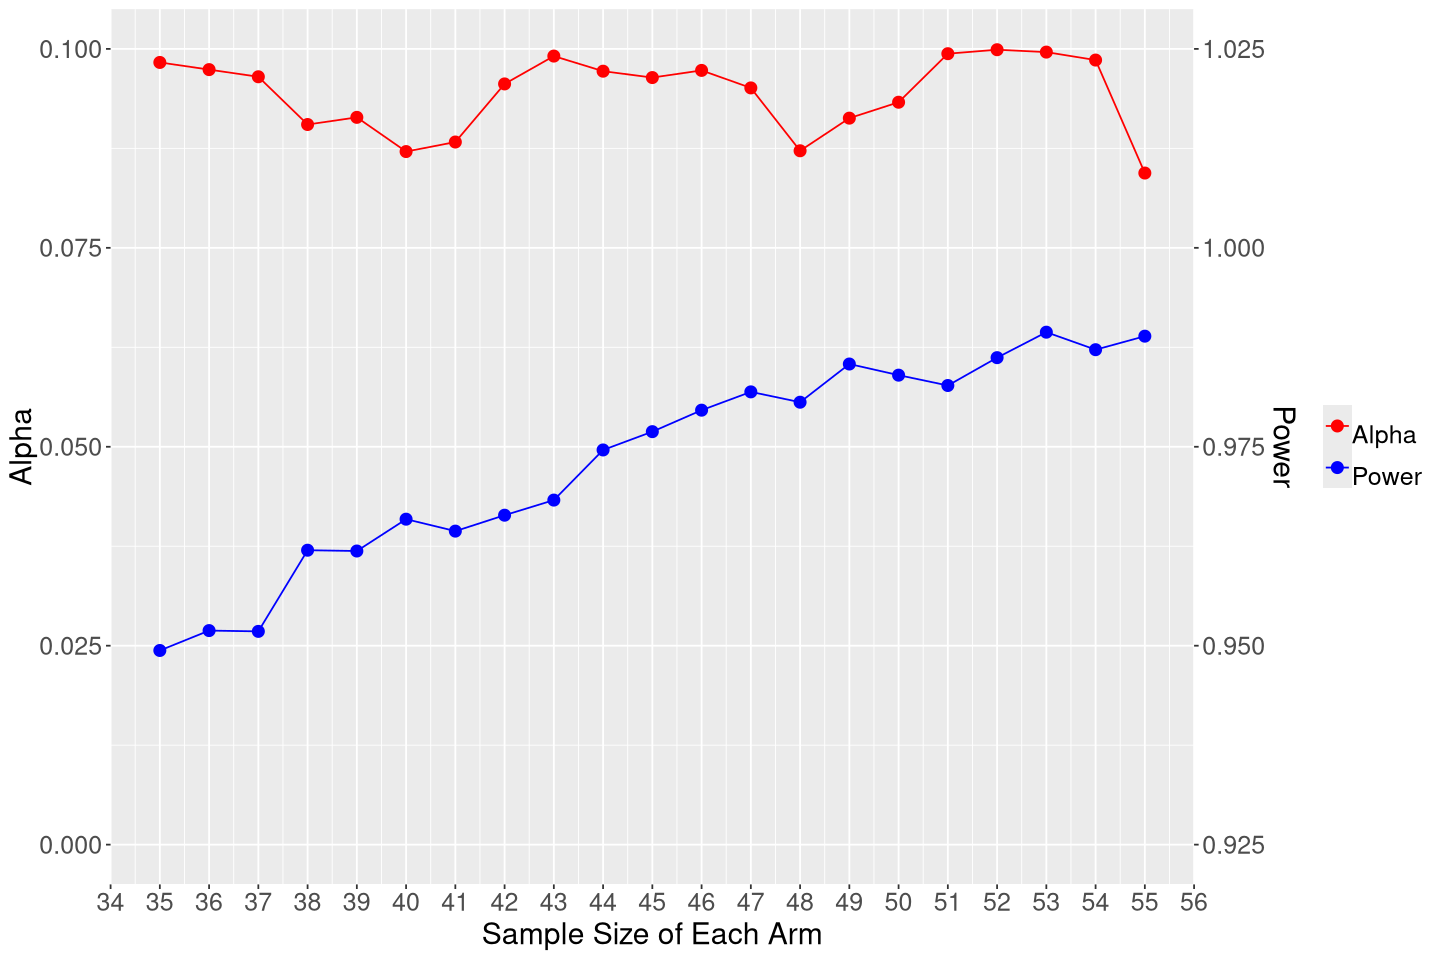

In [17]:
df <- as.data.frame(t(result_alln1[c(1,4,5),]))
options(repr.plot.width = 12, repr.plot.height = 8)

plot_n1 <- ggplot(df) +
  geom_point(data = df, aes(x = n1, y = alpha, color = "Alpha"),size = 3) +
  geom_point(data = df, aes(x = n1, y = (power - 0.925) , color = "Power"),size = 3) +
  geom_line(data = df, aes(x = n1, y = alpha, color = "Alpha")) +
  geom_line(data = df, aes(x = n1, y = (power - 0.925), color = "Power")) +
  scale_x_continuous(breaks = 33:58 ) +
  scale_y_continuous(limits = c(0, 0.1),
                     sec.axis = sec_axis(transform = ~ . + 0.925, name = "Power")) +
  scale_color_manual(values = c("Alpha" = "red", "Power" = "blue"),
                     labels = c("Alpha", "Power"))+
  theme(legend.title = element_blank(),
        axis.title = element_text(size = 18, margin = margin(t = 20)),
        axis.text = element_text(size = 15,margin = margin(t = 10)),
        legend.text = element_text(size = 15,margin = margin(t = 10))) +
  guides(color = guide_legend(title = "Scales"))+
  labs(x = "Sample Size of Each Arm", y = "Alpha")

plot_n1

## 2. The relationship between power and $\tau$ under this hypothesis.
Setting in Jung(2017)
#### $H_0 : \lambda_0 = \lambda_1 = 1.609$    
#### $H_1 : \lambda_0 = 1.609,\ \lambda_1 = 0.916$  

#### From the result in result_alln1 we can see that the sample size did not greatly affect the critical value $m_1,\ t_1$
#### So we set $n_1 = 51$. Search for the best m, t and calculate $\alpha$ and power under different $\tau$
If the preset $\tau$ is larger than $max(RMST_E)$, it will be adjusted to $max(RMST_E)$

In [4]:
set.seed(2024)
sim_size <- 10000 
acc_time <- 1.67
cen_time <- 1
n1 <- 51   #sample size per arm

data_C <- expo_gen_2stages(N = n1 * sim_size, acc_time = acc_time, lambda = 1.609, dist = 'exp', 
                            cen_time = cen_time,arm = 0, interim = 0)[ , c(4,5,1)]    
data_E_H0 <- expo_gen_2stages(N = n1 * sim_size, acc_time = acc_time, lambda = 1.609, dist = 'exp', 
                              cen_time = cen_time,arm = 1, interim = 0)[ , c(4,5,1)]
data_E_H1 <- expo_gen_2stages(N = n1 * sim_size, acc_time = acc_time, lambda = 0.916, dist = 'exp', 
                              cen_time = cen_time,arm = 1, interim = 0)[ , c(4,5,1)] 

result_alltau <- foreach(i = 1:20, .combine = 'cbind',.packages = 'foreach') %dopar% {  
    tau <- 0.6 + (i-1) * 0.1 
    rmst_h0 <- RMST_sim_cal(n = n1,data_E = data_E_H0, data_C = data_C,tau = tau,sim_size = sim_size)
    rmst_h1 <- RMST_sim_cal(n = n1,data_E = data_E_H1, data_C = data_C,tau = tau,sim_size = sim_size)
    opt_alpha <- 1
    opt_power <- 0
    opt_m1 <- 0
    opt_t1 <- 0
    opt_mt <- c()
     for (m1 in seq(from = -1, to = 1, by = 0.01))
         { # step = 1/100
         for (t1 in seq(from = 0, to = 1.5, by = 0.01)) # search 100 times in the interval
             {
                proc_h0 <- sum((rmst_h0[2, ] - rmst_h0[1, ] > m1) & (rmst_h0[2, ] > t1))
                proc_h1 <- sum((rmst_h1[2, ] - rmst_h1[1, ] > m1) & (rmst_h1[2, ] > t1))
                if (proc_h0/sim_size > 0 & proc_h0/sim_size < 0.1 & 
                    proc_h1/sim_size >= opt_power) # return the best 
                    {   
                        opt_alpha <- proc_h0 / sim_size
                        opt_power <- proc_h1 / sim_size
                        opt_m1 <- m1
                        opt_t1 <- t1
                        opt_mt <- c(tau, opt_m1, opt_t1, opt_alpha, opt_power)
                    }
              }
        }
    opt_mt
}


In [5]:
#load('/mnt/diff_tau_power.RData')  # The result of last loop is already saved
result_alltau <- data.frame(result_alltau)
rownames(result_alltau) <- c('tau', 'm1', 't1', 'alpha', 'power')
save(result_alltau, file = '/home/r27user6/RMST_Code/diff_tau_power.RData')
result_alltau

,result.1,result.2,result.3,result.4,result.5,result.6,result.7,result.8,result.9,result.10,result.11,result.12,result.13,result.14,result.15,result.16,result.17,result.18,result.19,result.20
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
tau,0.6000,0.7000,0.8000,0.9000,1.0000,1.1000,1.2000,1.3000,1.4000,1.5000,1.6000,1.7000,1.8000,1.9000,2.0000,2.1000,2.2000,2.3000,2.4000,2.5000
m1,-0.0400,-0.0500,0.0200,-0.0600,0.0100,-0.0700,-0.0700,-0.0700,-0.0800,-0.0700,-0.0600,-0.1400,-0.1300,-0.0500,-0.1200,-0.0800,-0.0100,-0.1200,-0.1200,-0.1200
t1,0.4300,0.4700,0.5000,0.5400,0.5600,0.5900,0.6100,0.6300,0.6400,0.6600,0.6700,0.6800,0.6900,0.6900,0.7000,0.7000,0.7000,0.7100,0.7100,0.7100
alpha,0.0725,0.0860,0.0995,0.0803,0.0989,0.0847,0.0869,0.0810,0.0975,0.0824,0.0876,0.0888,0.0866,0.0996,0.0936,0.0997,0.0993,0.0865,0.0869,0.0872
power,0.8773,0.9217,0.9304,0.9498,0.9609,0.9694,0.9767,0.9783,0.9840,0.9822,0.9850,0.9870,0.9875,0.9891,0.9878,0.9885,0.9874,0.9865,0.9866,0.9866


### How t1 and power changes across different $\tau$
#### $ \textcolor{lightgreen}{E(\tau)-C(\tau)>m_1\ \&\  E(\tau)>t_1}$ , where E and C are RMST value of two groups

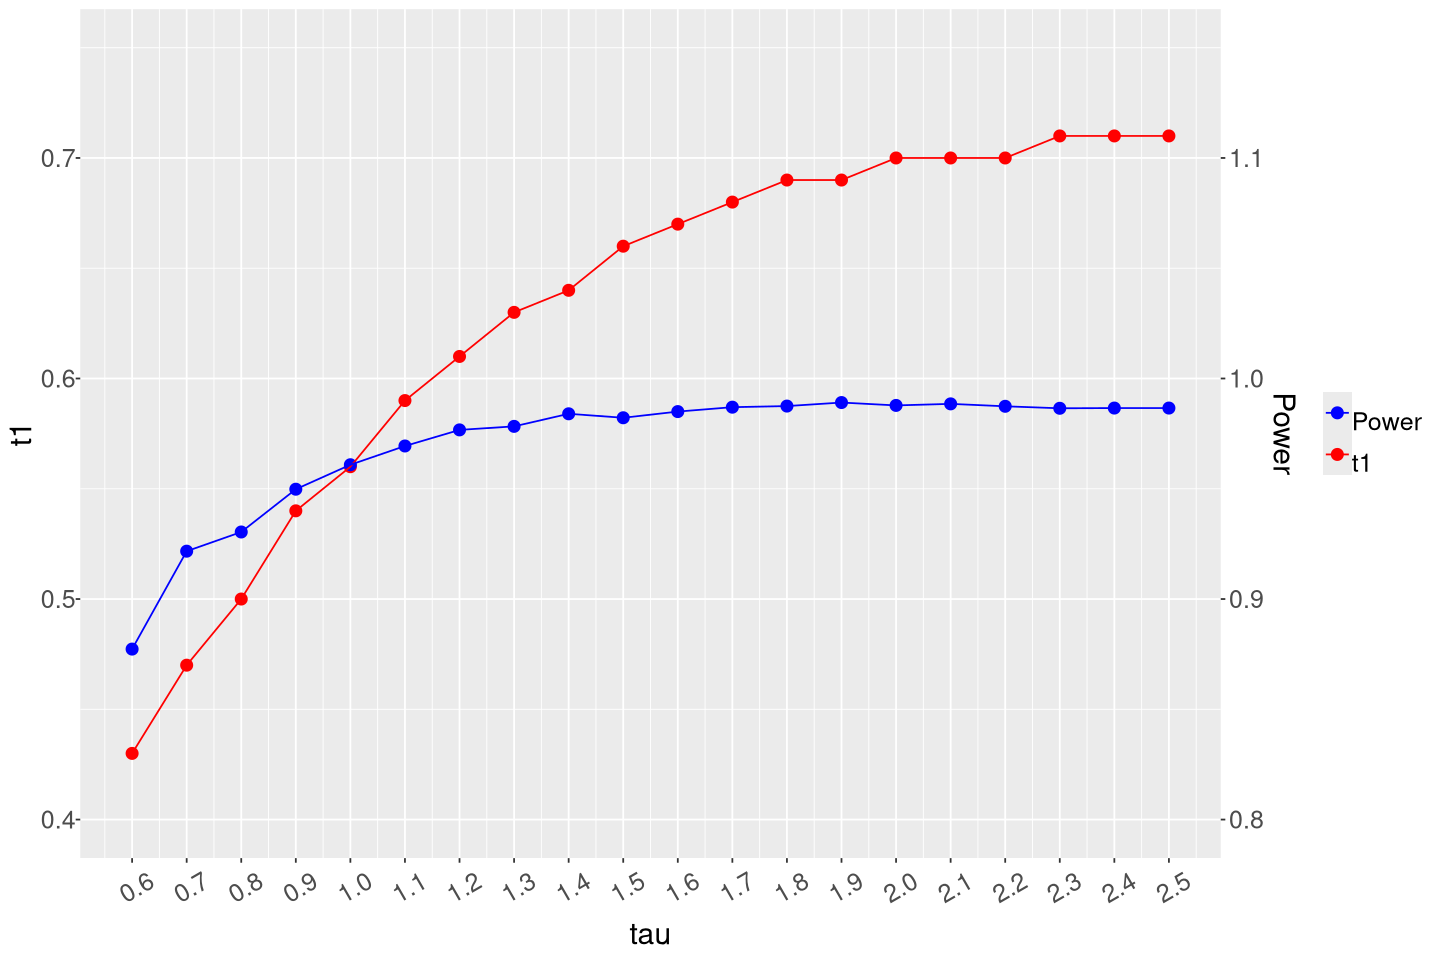

In [19]:
df <- as.data.frame(t(result_alltau[c(1,3,5),]))
plot_tau_ab <- ggplot(df) +
  geom_point(data = df, aes(x = tau, y = t1, color = "t1"),size = 3) +
  geom_point(data = df, aes(x = tau, y = (power - 0.4) , color = "Power"),size = 3) +
  geom_line(data = df, aes(x = tau, y = t1, color = "t1")) +
  geom_line(data = df, aes(x = tau, y = (power  - 0.4) , color = "Power")) +
  scale_x_continuous(name = "tau", breaks = df$tau) +
  scale_y_continuous(limits = c(0.4, 0.75),
                     sec.axis = sec_axis(transform = ~ . + 0.4, name = "Power")) +
  scale_color_manual(values = c("t1" = "red", "Power" = "blue"),
                     labels = c("Power", "t1"))+
  theme(legend.title = element_blank(),
        axis.title = element_text(size = 18, margin = margin(t = 20)),
        axis.text.x = element_text(angle = 30,size = 15,margin = margin(t = 10)),
        axis.text.y = element_text(size = 15,margin = margin(t = 10)),
        legend.text = element_text(size = 15,margin = margin(t = 10))) +
  guides(color = guide_legend(title = "Scales"))+
  labs(x = "tau", y = "t1")
plot_tau_ab

--------